# Matching the Cnmf-Seeded Components from Ground Truths with the Results of a CNMF Run

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.preprocessing import normalize
import time

import caiman as cm
from caiman.utils.utils import download_demo
from caiman.base.rois import extract_binary_masks_blob
from caiman.utils.visualization import plot_contours, view_patches_bar
from caiman.source_extraction.cnmf import cnmf as cnmf
from caiman.motion_correction import MotionCorrect, tile_and_correct, motion_correction_piecewise 
from caiman.components_evaluation import estimate_components_quality, evaluate_components, evaluate_components_CNN
from caiman.tests.comparison import comparison

2025-03-13 14:04:43.958247: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-13 14:04:43.980727: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-13 14:04:44.195957: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-13 14:04:44.264286: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741889084.358733 1282788 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741889084.38

### Loading Up the Ground Truth Files

In [2]:
#Neurofinder 03.00.test 
params_movie = {'fname': '/mnt/ceph/data/neuro/caiman/labeling/neurofinder.03.00.test/images/final_map/Yr_d1_498_d2_467_d3_1_order_C_frames_2250_.mmap',
                'p': 1,  # order of the autoregressive system
                'merge_thresh': 0.8,  # merging threshold, max correlation allow
                'rf': 25,  # half-size of the patches in pixels. rf=25, patches are 50x50    20
                'stride_cnmf': 10,  # amounpl.it of overlap between the patches in pixels
                'K': 4,  # number of components per patch
                # if dendritic. In this case you need to set init_method to sparse_nmf
                'is_dendrites': False,
                'init_method': 'greedy_roi',
                'gSig': [8, 8],  # expected half size of neurons
                'alpha_snmf': None,  # this controls sparsity
                'final_frate': 10,
                'r_values_min_patch': .5,  # threshold on space consistency
                'fitness_min_patch': -10,  # threshold on time variability
                # threshold on time variability (if nonsparse activity)
                'fitness_delta_min_patch': -5,
                'Npeaks': 5,
                'r_values_min_full': .8,
                'fitness_min_full': - 40,
                'fitness_delta_min_full': - 40,
                'only_init_patch': True,
                'gnb': 2,
                'memory_fact': 1,
                'n_chunks': 10,
                # whether to update the background components in the spatial phase
                'update_background_components': True,
                'low_rank_background': True  # whether to update the using a low rank approximation. In the False case all the nonzero elements of the background components are updated using hals
                #(to be used with one background per patch)
                }

#Neurofinder 04.00.test 
params_movie = {'fname': '/mnt/ceph/data/neuro/caiman/labeling/neurofinder.04.00.test/images/final_mapYr_d1_512_d2_512_d3_1_order_C_frames_3000_.mmap',
                'p': 1,  # order of the autoregressive system
                'merge_thresh': 0.8,  # merging threshold, max correlation allow
                'rf': 20,  # half-size of the patches in pixels. rf=25, patches are 50x50    20
                'stride_cnmf': 10,  # amounpl.it of overlap between the patches in pixels
                'K': 5,  # number of components per patch
                # if dendritic. In this case you need to set init_method to sparse_nmf
                'is_dendrites': False,
                'init_method': 'greedy_roi',
                'gSig': [5, 5],  # expected half size of neurons
                'alpha_snmf': None,  # this controls sparsity
                'final_frate': 10,
                'r_values_min_patch': .5,  # threshold on space consistency
                'fitness_min_patch': -10,  # threshold on time variability
                # threshold on time variability (if nonsparse activity)
                'fitness_delta_min_patch': -10,
                'Npeaks': 5,
                'r_values_min_full': .8,
                'fitness_min_full': - 40,
                'fitness_delta_min_full': - 40,
                'only_init_patch': True,
                'gnb': 2,
                'memory_fact': 1,
                'n_chunks': 10,
                # whether to update the background components in the spatial phase
                'update_background_components': True,
                'low_rank_background': True  # whether to update the using a low rank approximation. In the False case all the nonzero elements of the background components are updated using hals
                #(to be used with one background per patch)
                }

# neurofinder 02.00
params_movie = {'fname': '/mnt/ceph/data/neuro/caiman/labeling/neurofinder.02.00/images/final_map/Yr_d1_512_d2_512_d3_1_order_C_frames_8000_.mmap',
                'p': 1,  # order of the autoregressive system
                'merge_thresh': 0.8,  # merging threshold, max correlation allow
                'rf': 20,  # half-size of the patches in pixels. rf=25, patches are 50x50    20
                'stride_cnmf': 10,  # amounpl.it of overlap between the patches in pixels
                'K': 6,  # number of components per patch
                # if dendritic. In this case you need to set init_method to sparse_nmf
                'is_dendrites': False,
                'init_method': 'greedy_roi',
                'gSig': [5, 5],  # expected half size of neurons
                'alpha_snmf': None,  # this controls sparsity
                'final_frate': 10,
                'r_values_min_patch': .5,  # threshold on space consistency
                'fitness_min_patch': -10,  # threshold on time variability
                # threshold on time variability (if nonsparse activity)
                'fitness_delta_min_patch': -10,
                'Npeaks': 5,
                'r_values_min_full': .8,
                'fitness_min_full': - 40,
                'fitness_delta_min_full': - 40,
                'only_init_patch': True,
                'gnb': 2,
                'memory_fact': 1,
                'n_chunks': 10,
                # whether to update the background components in the spatial phase
                'update_background_components': True,
                'low_rank_background': True,  # whether to update the using a low rank approximation. In the False case all the nonzero elements of the background components are updated using hals
                #(to be used with one background per patch)
                'swap_dim': False,
                'crop_pix': 10
                }

### Parameters for the Movie

In [3]:
params_display = {
    'downsample_ratio': .2,
    'thr_plot': 0.8
}

# fname := name of the movie
fname_new = params_movie['fname']

## Run Analysis 

In [4]:
c, dview, n_processes = cm.cluster.setup_cluster(
    backend='local', n_processes=None, single_thread=False)

The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman


### Load MEMMAP File

### Correlation image

In [5]:
Yr, dims, T = cm.load_memmap(fname_new)
d1, d2 = dims
images = np.reshape(Yr.T, [T] + list(dims), order='F')
Y = np.reshape(Yr, dims + (T,), order='F')
m_images = cm.movie(images)

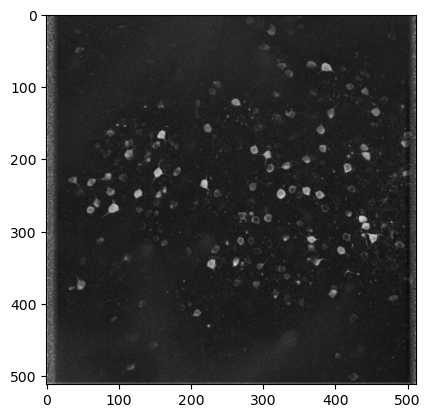

In [9]:
if m_images.shape[0] < 10000:
    Cn = m_images.local_correlations(
        swap_dim=params_movie['swap_dim'], frames_per_chunk=1500)
    Cn[np.isnan(Cn)] = 0
else:
    Cn = np.array(cm.load(('/'.join(fname_new.split('/')
                                    [:-3] + ['projections', 'correlation_image_better.tif'])))).squeeze()
plt.imshow(Cn, cmap='gray', vmax=.95)

In [10]:
# order of the autoregressive fit to calcium imaging in general one (slow gcamps) or two (fast gcamps fast scanning)
p = params_movie['p']
# merging threshold, max correlation allowed
merge_thresh = params_movie['merge_thresh']
# half-size of the patches in pixels. rf=25, patches are 50x50
rf = params_movie['rf']
# amounpl.it of overlap between the patches in pixels
stride_cnmf = params_movie['stride_cnmf']
# number of components per patch
K = params_movie['K']
# if dendritic. In this case you need to set init_method to sparse_nmf
is_dendrites = params_movie['is_dendrites']
# iinit method can be greedy_roi for round shapes or sparse_nmf for denritic data
init_method = params_movie['init_method']
# expected half size of neurons
gSig = params_movie['gSig']
# this controls sparsity
alpha_snmf = params_movie['alpha_snmf']
# frame rate of movie (even considering eventual downsampling)
final_frate = params_movie['final_frate']

if params_movie['is_dendrites'] == True:
    if params_movie['init_method'] is not 'sparse_nmf':
        raise Exception('dendritic requires sparse_nmf')
    if params_movie['alpha_snmf'] is None:
        raise Exception('need to set a value for alpha_snmf')

<>:23: SyntaxWarning: "is not" with 'str' literal. Did you mean "!="?
<>:23: SyntaxWarning: "is not" with 'str' literal. Did you mean "!="?
/tmp/ipykernel_2504237/270918655.py:23: SyntaxWarning: "is not" with 'str' literal. Did you mean "!="?
  if params_movie['init_method'] is not 'sparse_nmf':


### Extract spatial and temporal components on patches

In [13]:
# Extract spatial and temporal components on patches
t1 = time.time()

# TODO: warnings 3
cnm = cnmf.CNMF(n_processes=1, k=K, gSig=gSig, merge_thresh=params_movie['merge_thresh'], p=params_movie['p'],
                dview=dview, rf=rf, stride=stride_cnmf, memory_fact=1,
                method_init=init_method, alpha_snmf=alpha_snmf, only_init_patch=params_movie[
                    'only_init_patch'],
                gnb=params_movie['gnb'], method_deconvolution='oasis', border_pix=params_movie['crop_pix'], low_rank_background=params_movie['low_rank_background'])

In [14]:
cnm = cnm.fit(images)
print(cnm)

TypeError: unsupported operand type(s) for /: 'NoneType' and 'float'

In [15]:
A_tot = cnm.estimates.A
C_tot = cnm.estimates.C
YrA_tot = cnm.estimates.YrA
b_tot = cnm.estimates.b
f_tot = cnm.estimates.f
sn_tot = cnm.estimates.sn

print(('Number of components:' + str(A_tot.shape[-1])))
plt.figure()

AttributeError: 'NoneType' object has no attribute 'shape'

In [13]:
crd = plot_contours(A_tot, Cn, thr=params_display['thr_plot'])

<>:24: SyntaxWarning: "is not" with 'str' literal. Did you mean "!="?
<>:24: SyntaxWarning: "is not" with 'str' literal. Did you mean "!="?
/tmp/ipykernel_1140582/2765719556.py:24: SyntaxWarning: "is not" with 'str' literal. Did you mean "!="?
  if params_movie['init_method'] is not 'sparse_nmf':


TypeError: unsupported operand type(s) for /: 'NoneType' and 'float'

In [16]:
# DISCARD LOW QUALITY COMPONENT
final_frate = params_movie['final_frate']
# threshold on space consistency
r_values_min = params_movie['r_values_min_patch']
# threshold on time variability
fitness_min = params_movie['fitness_delta_min_patch']
# threshold on time variability (if nonsparse activity)
fitness_delta_min = params_movie['fitness_delta_min_patch']
Npeaks = params_movie['Npeaks']
traces = C_tot + YrA_tot

# TODO: todocument
idx_components, idx_components_bad = estimate_components_quality(
    traces, Y, A_tot, C_tot, b_tot, f_tot, final_frate=final_frate, Npeaks=Npeaks, r_values_min=r_values_min,
    fitness_min=fitness_min, fitness_delta_min=fitness_delta_min)
print(('Keeping ' + str(len(idx_components)) +
       ' and discarding  ' + str(len(idx_components_bad))))

TypeError: unsupported operand type(s) for +: 'NoneType' and 'NoneType'

In [ ]:
plt.figure()
crd = plot_contours(
    A_tot.tocsc()[:, idx_components], Cn, thr=params_display['thr_plot'])

A_tot = A_tot.tocsc()[:, idx_components]
C_tot = C_tot[idx_components]

# Rerun updating the components to refine
t1 = time.time()
cnm = cnmf.CNMF(n_processes=1, k=A_tot.shape, gSig=gSig, merge_thresh=merge_thresh, p=p, dview=dview, Ain=A_tot,
                Cin=C_tot, b_in=b_tot,
                f_in=f_tot, rf=None, stride=None, method_deconvolution='oasis', gnb=params_movie['gnb'],
                low_rank_background=params_movie['low_rank_background'], update_background_components=params_movie['update_background_components'])

In [ ]:
cnm = cnm.fit(images)
print(cnm)

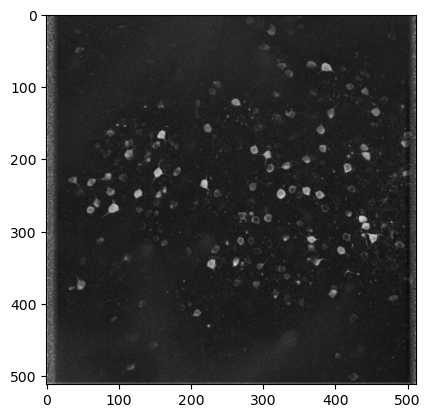

In [11]:
if m_images.shape[0] < 10000:
    Cn = m_images.local_correlations(
        swap_dim=params_movie['swap_dim'], frames_per_chunk=1500)
    Cn[np.isnan(Cn)] = 0
else:
    Cn = np.array(cm.load(('/'.join(fname_new.split('/') 
                                    [:-3] + ['projections', 'correlation_image_better.tif'])))).squeeze()
plt.imshow(Cn, cmap='gray', vmax=.95)

In [ ]:
A, C, b, f, YrA, sn = cnm.estimates.A, cnm.estimates.C, cnm.estimates.b, cnm.estimates.f, cnm.estimates.YrA, cnm.estimates.sn
# %% again recheck quality of components, stricter criteria
final_frate = params_movie['final_frate']
# threshold on space consistency
r_values_min = params_movie['r_values_min_full']
fitness_min = params_movie['fitness_min_full']  # threshold on time variability
# threshold on time variability (if nonsparse activity)
fitness_delta_min = params_movie['fitness_delta_min_full']
Npeaks = params_movie['Npeaks']
traces = C + YrA
idx_components, idx_components_bad, fitness_raw, fitness_delta, r_values = estimate_components_quality(
    traces, Y, A, C, b, f, final_frate=final_frate, Npeaks=Npeaks, r_values_min=r_values_min, fitness_min=fitness_min,
    fitness_delta_min=fitness_delta_min, return_all=True)
print(' ***** ')
print((len(traces)))
print((len(idx_components)))

# 
np.savez(os.path.join(os.path.split(fname_new)[0], os.path.split(fname_new)[1][:-4] + 'results_analysis.npz'), Cn=Cn, fname_new=fname_new,
         A=A,
         C=C, b=b, f=f, YrA=YrA, sn=sn, d1=d1, d2=d2, idx_components=idx_components,
         idx_components_bad=idx_components_bad,
         fitness_raw=fitness_raw, fitness_delta=fitness_delta, r_values=r_values)

# TODO: show screenshot 14
pl.subplot(1, 2, 1)
crd = plot_contours(A.tocsc()[:, idx_components],
                    Cn, thr=params_display['thr_plot'])
pl.subplot(1, 2, 2)
crd = plot_contours(A.tocsc()[:, idx_components_bad],
                    Cn, thr=params_display['thr_plot'])


view_patches_bar(Yr, scipy.sparse.coo_matrix(A.tocsc()[:, idx_components]), C[idx_components, :], b, f, dims[0], dims[1],
                 YrA=YrA[idx_components, :], img=Cn)

view_patches_bar(Yr, scipy.sparse.coo_matrix(A.tocsc()[:, idx_components_bad]), C[idx_components_bad, :], b, f, dims[0],
                 dims[1], YrA=YrA[idx_components_bad, :], img=Cn)

### Load Data

In [ ]:
params_display = {
    'downsample_ratio': .2,
    'thr_plot': 0.8
}

try:
    fname_new = fname_new[()]
except:
    pass
    
#analysis_file = '/mnt/ceph/neuro/jeremie_analysis/neurofinder.03.00.test/Yr_d1_498_d2_467_d3_1_order_C_frames_2250_._results_analysis.npz'
with np.load(os.path.join(os.path.split(fname_new)[0], os.path.split(fname_new)[1][:-4] + 'results_analysis.npz')) as ld:
    print(ld.keys())
    locals().update(ld)
    dims_off = d1, d2
    A = scipy.sparse.coo_matrix(A[()])
    dims = (d1, d2)
    gSig = params_movie['gSig']
    fname_new = fname_new[()]

In [ ]:
predictions, final_crops = evaluate_components_CNN(
    A, dims, gSig, model_name='model/cnn_model')

cm.movie(final_crops).play(gain=3, magnification=6, fr=5)
cm.movie(np.squeeze(final_crops[np.where(predictions[:, 1] >= 0.5)[0]])).play(
    gain=2., magnification=5, fr=5)
cm.movie(np.squeeze(final_crops[np.where(predictions[:, 0] >= 0.5)[0]])).play(
    gain=2., magnification=5, fr=5)

In [ ]:
thresh = .5
idx_components_cnn = np.where(predictions[:, 1] >= thresh)[0]
idx_components_bad_cnn = np.where(predictions[:, 0] > (1 - thresh))[0]

print(' ***** ')
print((len(final_crops)))
print((len(idx_components_cnn)))

idx_components_r = np.where((r_values >= .5))[0]
idx_components_raw = np.where(fitness_raw < -5)[0]
idx_components_delta = np.where(fitness_delta < -5)[0]

idx_components = np.union1d(idx_components_r, idx_components_raw)
idx_components = np.union1d(idx_components, idx_components_delta)
idx_components_bad = np.setdiff1d(list(range(len(r_values))), idx_components)

In [ ]:
print(' ***** ')
print((len(r_values)))
print((len(idx_components)))

plt.subplot(1, 2, 1)
crd = plot_contours(A.tocsc()[:, idx_components],
                    Cn, thr=params_display['thr_plot'], vmax=0.35)
plt.subplot(1, 2, 2)
crd = plot_contours(A.tocsc()[:, idx_components_bad],
                    Cn, thr=params_display['thr_plot'], vmax=0.35)

## Run Analysis 

In [ ]:
c, dview, n_processes = cm.cluster.setup_cluster(
    backend='local', n_processes=None, single_thread=False)

gt_file = os.path.join(os.path.split(fname_new)[0], os.path.split(
    fname_new)[1][:-4] + 'match_masks.npz')

with np.load(gt_file) as ld:
    print(ld.keys())
    locals().update(ld)
    A_gt = scipy.sparse.coo_matrix(A_gt[()])
    dims = (d1, d2)

view_patches_bar(Yr, scipy.sparse.coo_matrix(A_gt.toarray()[
                 :, idx_components_gt]), C_gt[idx_components_gt], b, f, dims[0], dims[1], YrA=YrA_gt[idx_components_gt], img=Cn)

In [ ]:
dist_A = (normalize(A_gt.tocsc()[:, idx_components_gt], axis=0).T.dot(
    normalize(A.tocsc()[:, :], axis=0))).toarray()
dist_C = normalize(C_gt[idx_components_gt], axis=1).dot(
    normalize(C[:], axis=1).T)
dist_A = dist_A * (dist_A > 0)

plt.figure(figsize=(30, 20))
tp_gt, tp_comp, fn_gt, fp_comp, performance_cons_off = cm.base.rois.nf_match_neurons_in_binary_masks(A_gt.toarray()[:, idx_components_gt].reshape([dims[0], dims[1], -1], order='F').transpose([2, 0, 1]),
                                                                                                     A.toarray()[:, :].reshape([dims[0], dims[1], -1], order='F').transpose([2, 0, 1]), thresh_cost=.7, min_dist=10,
                                                                                                     print_assignment=False, plot_results=True, Cn=Cn, labels=['GT', 'Offline'], D=[1 - dist_A * (dist_C > .8)])
plt.rcParams['pdf.fonttype'] = 42
font = {'family': 'Myriad Pro',
        'weight': 'regular',
        'size': 20}
plt.rc('font', **font)

idx_final = tp_comp[np.where(dist_A[tp_gt, tp_comp] > 0.7)[0]]
view_patches_bar(Yr, scipy.sparse.coo_matrix(A.toarray()[
                 :, idx_final]), C[idx_final], b, f, dims[0], dims[1], YrA=YrA[idx_final], img=Cn)

view_patches_bar(Yr, scipy.sparse.coo_matrix(A.toarray()[
                 :, fp_comp]), C[fp_comp], b, f, dims[0], dims[1], YrA=YrA[fp_comp], img=Cn)

view_patches_bar(Yr, scipy.sparse.coo_matrix(A_gt.toarray()[
                 :, fn_gt]), C_gt[fn_gt], b_gt, f_gt, dims[0], dims[1], YrA=YrA_gt[fn_gt], img=Cn)

plt.hist(r_values[tp_comp], 30)

In [ ]:
np.savez(os.path.join(os.path.split(fname_new)[0], os.path.split(fname_new)[1][:-4] + '_training_set.npz'), fname_new=fname_new,
         A_seeded=A_gt.tocsc()[
    :, idx_components_gt], C_seeded=C_gt[idx_components_gt], YrA_seeded=YrA_gt[idx_components_gt],
    A_matched=A.tocsc()[
    :, idx_final], C_matched=C[idx_final], YrA_matched=YrA[idx_final],
    A_unmatched=A_gt.tocsc()[
    :, fn_gt], C_unmatched=C_gt[fn_gt], YrA_unmatched=YrA_gt[fn_gt],
    A_negative=A.tocsc()[
    :, fp_comp], C_negative=C[fp_comp], YrA_negative=YrA[fp_comp],
    r_values=r_values, fitness_delta=fitness_delta, fitness_raw=fitness_raw, Cn=Cn, dims=dims
)

with np.load(os.path.join(os.path.split(fname_new)[0], os.path.split(fname_new)[1][:-4] + '_training_set.npz')) as ld:
    print(ld.keys())
    locals().update(ld)
    fname_new = fname_new[()]

### Plots

In [ ]:
thr = 0.98
pl.subplot(1, 3, 1)
crd = plot_contours(A_matched[()], Cn, thr=thr)
pl.subplot(1, 3, 2)
crd = plot_contours(A_unmatched[()], Cn, thr=thr)
pl.subplot(1, 3, 3)
crd = plot_contours(A_negative[()], Cn, thr=thr)

plt.subplot(1, 3, 1)
crd = pl.imshow(A_matched[()].sum(1).reshape(
    dims, order='F'), vmax=A_matched[()].max() * .2)
plt.subplot(1, 3, 2)
crd = pl.imshow(A_unmatched[()].sum(1).reshape(
    dims, order='F'), vmax=A_unmatched[()].max() * .2)
plt.subplot(1, 3, 3)
crd = pl.imshow(A_negative[()].sum(1).reshape(
    dims, order='F'), vmax=A_negative[()].max() * .2)

### Maskings

In [ ]:
# Don't think it is needed
masks_sue = scipy.io.loadmat('/mnt/xfs1/home/agiovann/Downloads/yuste_sue_masks.mat')

with h5py.File('/mnt/xfs1/home/agiovann/Downloads/yuste_1.protoroi.mat')as f:
    print(f.keys())
    print(list(f['repository']))
    proto = f['prototypes']
    print(list(proto['params']))
    print(proto.keys())
    spatial = proto['spatial']
    print(spatial.keys())
    locals().update((dict(spatial.attrs.iteritems())))
    locals().update({k: np.array(l) for k, l in spatial.iteritems()})